In [1]:
code_dir = "../UXO_protected/+BTInvertPY"

In [2]:
import numpy as np
import os
import h5py
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import cm as cmap
from matplotlib import colors
from matplotlib.colors import Normalize
from mpl_toolkits import mplot3d

import uxo_utils
from uxo_utils import (
    SensorInfo, Model, preCalcLoopCorners, FModParam, 
    forwardWithQ, sensorCoords2RxCoords, hprimary, formQmatrix
)

In [3]:
from matplotlib import rcParams
rcParams['font.size'] = 14
np.random.seed(2020)

## load sensor info and ordnance data

In [4]:
sensorinfo = uxo_utils.load_sensor_info()
ordnance = uxo_utils.load_ordnance_dict()

In [5]:
ordnance.keys()

dict_keys(['105mm', '2.36-in', '2.75-in', '2.95-in', '20-lb Bomb', '25-lb Bomb', '3-in', '3.5-in', '30mm', '37mm', '4-in', '4-in Sphere', '4.2-in', '4.5-in', '4.52-in', '5-lb Bomb', '57mm', '60mm', '66mm', '75mm', '76mm', '81mm', '90mm', '106mm', 'ISO Large', 'ISO Medium', 'ISO Small', '2.25-in'])

## set up survey parameters
- x is cross-line
- y is inline

In [6]:
ntx = len(sensorinfo.transmitters)
ymax = 2. 
y_spacing = 0.2
dy = y_spacing / ntx
nloc = int(ymax/dy)
ncycles = int(nloc/ntx)

y = np.linspace(0, ymax-dy, nloc)
x = np.zeros(nloc)
z = 0.28 * np.ones(nloc)

pitch = np.zeros(nloc)
roll = np.zeros(nloc)
yaw = np.zeros(nloc)  # moving north (sensor in typical orientation)

txnum = np.kron(np.ones(ncycles), np.arange(ntx))

In [7]:
# Convert sensor location coordinates to Rx locations
pos, mnum = sensorCoords2RxCoords(
    sensorinfo=sensorinfo,
    x = x, 
    y = y, 
    z = z, 
    pitch = pitch, 
    roll = roll, 
    yaw = yaw,
    txnum = txnum
)

pitch = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(pitch)])
roll = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(roll)])
yaw = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(yaw)])
pos = np.concatenate(pos,axis=0)

In [8]:
for i in range(3):
    print(pos[:, i].min(), pos[:, i].max())

-1.0 1.0
-0.25 2.21
0.28 0.28


# ordnance objects

In [9]:
times = ordnance["ISO Small"]["times"]

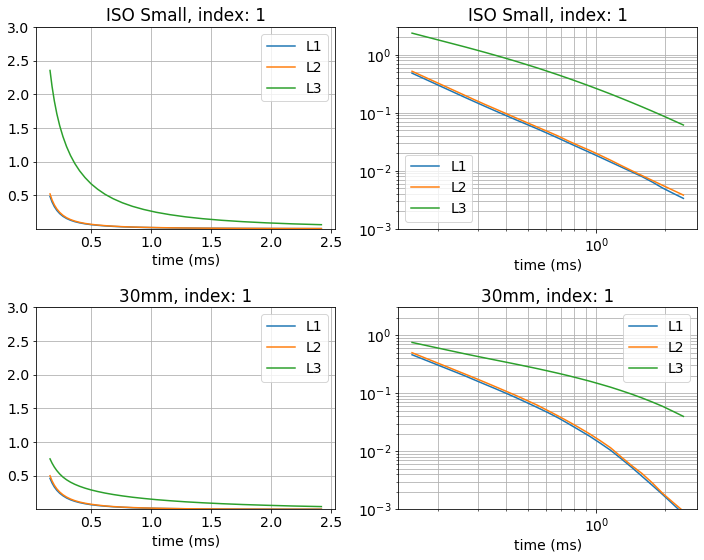

In [10]:
plot_me = {
    "ISO Small": 1,
    "30mm": 1
}
fig, ax = plt.subplots(len(plot_me.keys()), 2, figsize=(10, 4*len(plot_me.keys())))

for i, key in enumerate(plot_me.keys()):
    for l in ["L1", "L2", "L3"]:
        L = ordnance[key][l][plot_me[key]]
        ax[i, 0].plot(times, L, label=l)
        ax[i, 1].loglog(times, L, label=l)

    for a in ax[i, :]:
        a.set_title(f"{key}, index: {1}")
        a.grid(which="both")
        a.legend()
        a.set_xlabel("time (ms)")
        a.set_ylim([1e-3, 3])
        
plt.tight_layout()

# ranges of parameters

In [11]:
depth_range_iso_small = np.r_[0.2, 0.7]
depth_range_30mm = np.r_[0.1, 0.5]

x_range = np.r_[-1.25, 1.25]
y_range = np.r_[0., ymax]

yaw_range = np.r_[0, 2*np.pi]
pitch_range = np.r_[0, 2*np.pi]
roll_range = np.r_[0, 2*np.pi]

def generate_random_variables(n, bounds):
    return bounds.min() + (bounds.max() - bounds.min()) * np.random.rand(n)

In [12]:
ntrain = 2048*2 #*4
ntest = 1024
nvalid = 1024

class_dict = {
    0: "not TOI",
    1: "ISO Small",
    2: "30mm"
}
n_class = len(class_dict.keys())

In [13]:
labels_train = np.random.choice(n_class, ntrain)
labels_test = np.random.choice(n_class, ntest)
labels_valid = np.random.choice(n_class, nvalid)

def generate_parameters(labels):
    n = len(labels)
    i0 = labels == 0
    i1 = labels == 1
    i2 = labels == 2
    
    depths = np.zeros(n)
    depths[i1] = generate_random_variables(i1.sum(), depth_range_iso_small)
    depths[i2] = generate_random_variables(i2.sum(), depth_range_30mm)
    
    x = generate_random_variables(n, x_range)
    y = generate_random_variables(n, y_range)
    z = -depths
    
    yaw = generate_random_variables(n, yaw_range)
    pitch = generate_random_variables(n, pitch_range)
    roll = generate_random_variables(n, roll_range)
    
    return pd.DataFrame({
        "label": labels,
        "depth": depths,
        "x": x,
        "y": y,
        "z": z,
        "yaw": yaw,
        "pitch": pitch,
        "roll": roll
    })

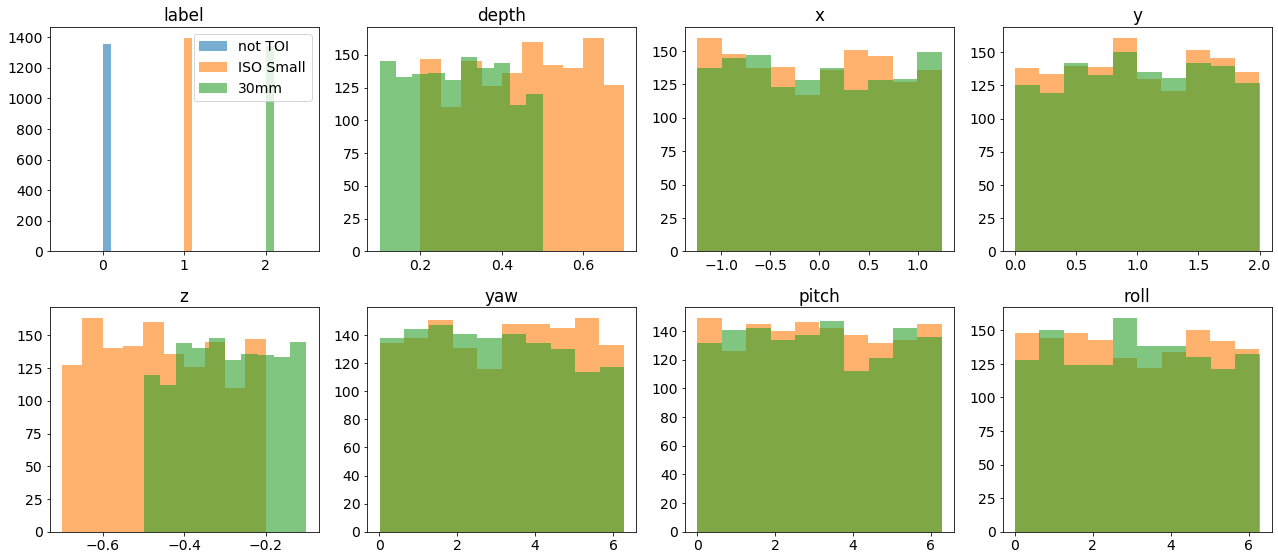

In [14]:
params_train = generate_parameters(labels_train) 
params_test = generate_parameters(labels_test) 
params_valid = generate_parameters(labels_valid) 

fig, ax = plt.subplots(2, 4, figsize=(18, 8))
ax = ax.flatten()

i = 0
for key, val in params_train.items():
    for j in range(3):
        if key != "label" and j ==0: 
            pass  # these parameters are irrelevant if there is no object
        else:
            inds = labels_train == j
            ax[i].hist(val[inds], 10, color=f"C{j}", alpha=0.6)
    ax[i].set_title(key)
    i += 1

ax[0].legend([class_dict[0], class_dict[1], class_dict[2]])
plt.tight_layout()

# set up forward simulations

In [15]:
# figuring out where all of the vertices are in coordinate system -- gives us location of vertices 
Tx_indices_rot, Rx_indices_rot = preCalcLoopCorners(
    sensorinfo=sensorinfo, mnum=mnum, rlist=pos, pitch=pitch, roll=roll, yaw=yaw
) 

# convienence object for inputs to fwd modelling 
st = FModParam(sensorinfo, pos, mnum, times, Tx_indices_rot, Rx_indices_rot)  

In [16]:
def run_simulations(parameters, st=st, mnum=mnum, ncycles=ncycles):
    data = []
    for i, l in enumerate(parameters["label"]):
        if l == 0:
            # this can later be replaced with random noise or other structured but uninteresting signal
            V = np.zeros((pos.shape[0], len(times)))
        else: 
            xyz = np.r_[parameters["x"][i], parameters["y"][i], parameters["z"][i]]
            ypr = np.r_[parameters["yaw"][i], parameters["pitch"][i], parameters["roll"][i]]
            L3 = ordnance[class_dict[l]]["L3"][1]
            L2 = ordnance[class_dict[l]]["L2"][1]
            L1 = ordnance[class_dict[l]]["L1"][1]
            
            mod = Model(xyz=xyz, gba=ypr, l3=L3, l2=L2, l1=L1, times=times)
            V = forwardWithQ(mod, st) # nT/s (some version of db/dt)
        V = V.reshape(ncycles, mnum.max()+1, len(times))
        V = np.swapaxes(V, 0, 1)
        data.append(V)
    return data
    
    

In [17]:
%%time
data_train = run_simulations(params_train)

CPU times: user 16.1 s, sys: 1.86 s, total: 18 s
Wall time: 3.06 s


In [18]:
%%time
data_test = run_simulations(params_test)
data_valid = run_simulations(params_valid)

CPU times: user 8.2 s, sys: 1 s, total: 9.2 s
Wall time: 1.57 s


In [19]:
time_scaling = (times)
time_scaling

array([0.154, 0.171, 0.19 , 0.211, 0.235, 0.262, 0.292, 0.325, 0.361,
       0.401, 0.446, 0.496, 0.551, 0.613, 0.681, 0.758, 0.842, 0.936,
       1.04 , 1.156, 1.286, 1.429, 1.588, 1.764, 1.961, 2.178, 2.42 ])

In [20]:
scaled_data_train = [d*time_scaling for d in data_train]
scaled_data_test = [d*time_scaling for d in data_test]
scaled_data_valid = [d*time_scaling for d in data_valid]

## plot some sample data

In [21]:
pos = np.swapaxes(pos.reshape(ncycles, mnum.max()+1, 3), 0, 1)

In [22]:
dind = 3
d = data_train[dind]

print(f"class: {class_dict[labels_train[dind]]}, data shape: {d.shape}")

params_train.iloc[dind]

class: ISO Small, data shape: (165, 10, 27)


label    1.000000
depth    0.633196
x        0.553952
y        0.576880
z       -0.633196
yaw      4.906350
pitch    2.337540
roll     1.460792
Name: 3, dtype: float64

In [23]:
# tx_num, rx_num, rx_comp, rxcube
sensor_table = sensorinfo.measNum2TxRxRxcCube()

In [24]:
len(sensor_table)

165

Text(0.5, 0.92, 'Transmitter 1, Target 3: ISO Small')

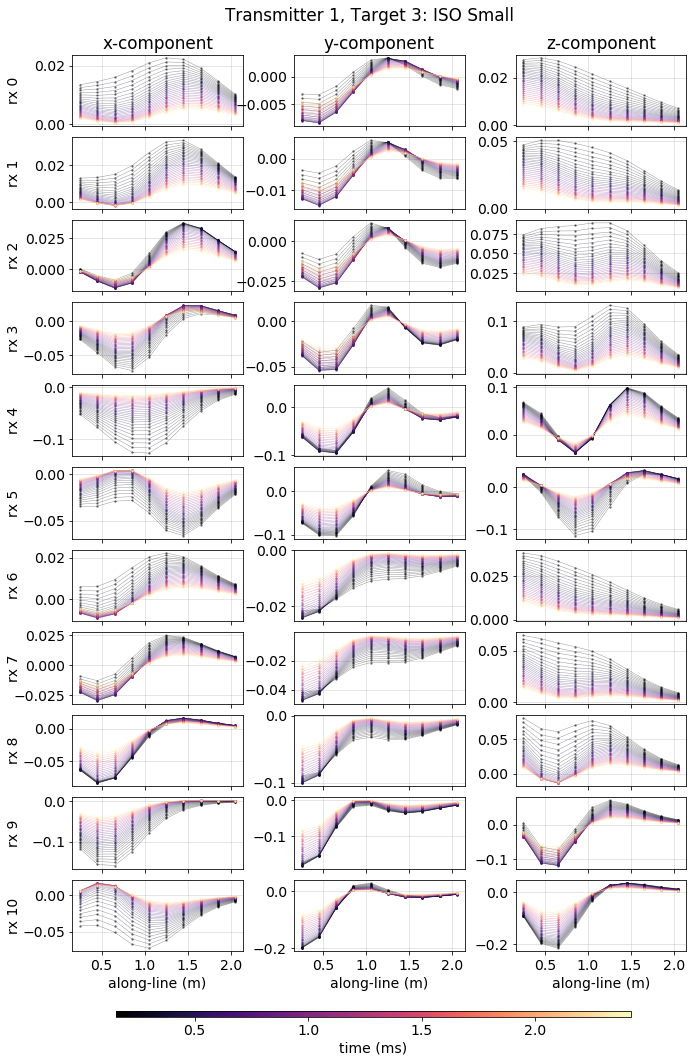

In [25]:
nrx = 11
fig, ax = plt.subplots(nrx, 3, figsize=(11, 1.5*nrx))
fig.subplots_adjust(wspace=0.3, hspace=0.15)

plot_tx = 0
tx_inds = (sensor_table[:, 0] == plot_tx)

cm = plt.get_cmap('magma')
c_norm = Normalize(vmin=times.min(), vmax=times.max())
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

d = scaled_data_train[dind]

for rx in range(nrx):
    ii = tx_inds & (sensor_table[:, 3] == rx)
    for a, comp in zip(ax[rx, :], [0, 1, 2]):
        mnumind = np.where( ii & (sensor_table[:, 2] == comp))[0][0]
        for t in range(len(times)):
            a.plot(
                pos[mnumind, :, 1], d[mnumind, :, t], 
                color=scalar_map.to_rgba(times[t]), marker=".", lw=0.5, alpha=0.4, ms=3
            )

        a.grid(which="both", alpha=0.4)
        if rx < nrx-1:
            a.set_xticklabels('')
        else:
            a.set_xlabel("along-line (m)")
        
        if rx == 0:
            if comp == 0:
                a.set_title("x-component")
            elif comp == 1:
                a.set_title("y-component")
            elif comp == 2:
                a.set_title("z-component")
        
        if comp == 0:
            a.set_ylabel(f"rx {rx}")
            a.yaxis.set_label_coords(-0.3, 0.5)
            
# plt.tight_layout()
cbar_ax = fig.add_axes([0.18, 0.07, 0.65, 0.005])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (ms)')

fig.suptitle(f"Transmitter {plot_tx+1}, Target {dind}: {class_dict[labels_train[dind]]}", y=0.92)


Text(0.5, 0.92, 'Transmitter 1, Target 3: ISO Small')

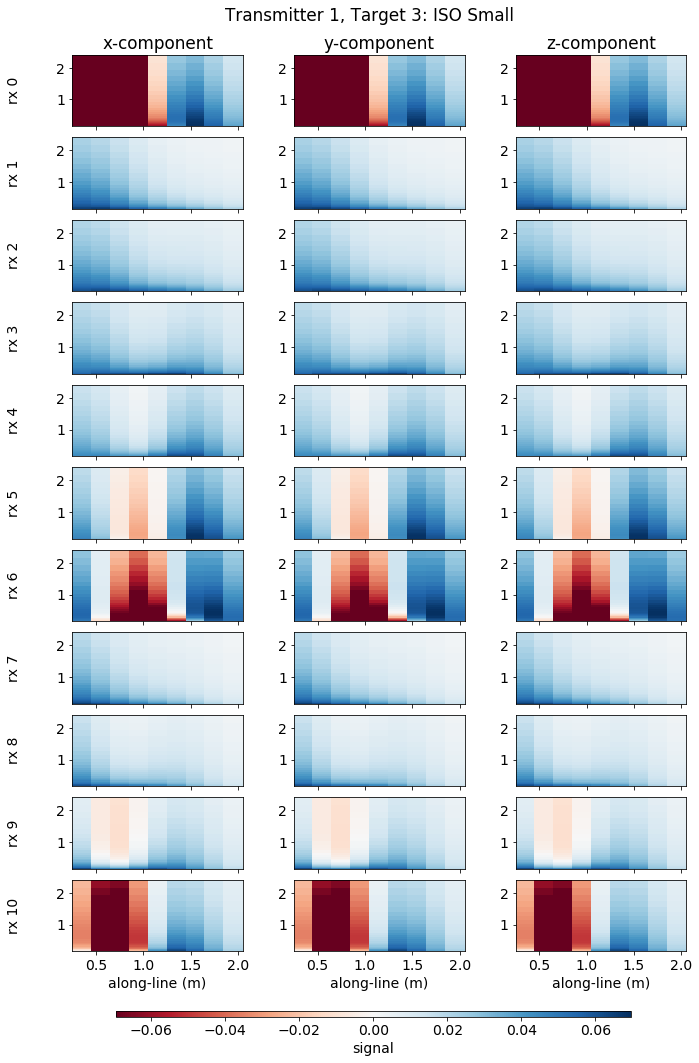

In [26]:
nrx = 11
fig, ax = plt.subplots(nrx, 3, figsize=(11, 1.5*nrx))
fig.subplots_adjust(wspace=0.3, hspace=0.15)

plot_tx = 0
tx_inds = (sensor_table[:, 0] == plot_tx)

d = scaled_data_train[dind]

for rx in range(nrx):
    ii = tx_inds & (sensor_table[:, 3] == rx)
    plotme = d[mnumind, :, :].T
    for a, comp in zip(ax[rx, :], [0, 1, 2]):
        mnumind = np.where( ii & (sensor_table[:, 2] == comp))[0][0]
        out = a.pcolormesh(
            pos[mnumind, :, 1], times, 
            plotme, cmap="RdBu", vmin=-(np.abs(plotme.max())).max(), vmax=(np.abs(plotme.max())).max()
        )

#         a.grid(which="both", alpha=0.4)
#         a.set_aspect(1)
        if rx < nrx-1:
            a.set_xticklabels('')
        else:
            a.set_xlabel("along-line (m)")
        
        if rx == 0:
            if comp == 0:
                a.set_title("x-component")
            elif comp == 1:
                a.set_title("y-component")
            elif comp == 2:
                a.set_title("z-component")
        
        if comp == 0:
            a.set_ylabel(f"rx {rx}")
            a.yaxis.set_label_coords(-0.3, 0.5)

cbar_ax = fig.add_axes([0.18, 0.07, 0.65, 0.005])
cb = plt.colorbar(out, cbar_ax, orientation="horizontal")
cb.set_label('signal')

fig.suptitle(f"Transmitter {plot_tx+1}, Target {dind}: {class_dict[labels_train[dind]]}", y=0.92)


# build a ConvNet classifier 

In [27]:
import torch
from torch import nn
from torch.nn import functional

In [28]:
use_scaled = True
if use_scaled is True: 
    X_train = torch.from_numpy(np.float32(np.stack(scaled_data_train, axis=0)))
    X_test = torch.from_numpy(np.float32(np.stack(scaled_data_test, axis=0)))
    X_valid = torch.from_numpy(np.float32(np.stack(scaled_data_valid, axis=0)))

elif use_scaled is False: 
    X_train = torch.from_numpy(np.float32(np.stack(data_train, axis=0)))
    X_test = torch.from_numpy(np.float32(np.stack(data_test, axis=0)))
    X_valid = torch.from_numpy(np.float32(np.stack(data_valid, axis=0)))


C_train = torch.from_numpy(np.float32(labels_train)).long()
C_test = torch.from_numpy(np.float32(labels_test)).long()
C_valid = torch.from_numpy(np.float32(labels_valid)).long()

In [29]:
class ConvNet(nn.Module):
    
    def __init__(self, network_geometry):
        super().__init__()
        self.network_geometry=network_geometry
        self.nt = len(network_geometry)
    
    def forward(self, X, K, batch_norm):  
        for i, Ki, bn in zip(range(self.nt), K, batch_norm):
            z = functional.conv2d(X, Ki, stride=1, padding=1)
            z = bn(z)
            z = functional.relu(z)
            z = functional.max_pool2d(z, 3, stride=1, padding=1)
            X = z
        return X

In [30]:
in_channels = 165
n_class = 3
layer_geometries = [in_channels, 33, 11] #11, 11, 11]
nlayers = len(layer_geometries)
initial_scaling = 1e-3

width = nloc//ntx
ntimes = len(times)

# initialize K's and batch normalizations
K = []
batch_norm = []
bias = []
for i in range(nlayers-1):
    n_in = layer_geometries[i]
    n_out = layer_geometries[i+1]
    Ki = nn.Parameter(torch.Tensor(n_out, n_in, 3, 3))
    Ki.data = torch.randn(n_out, n_in, 3, 3)  * initial_scaling
    K.append(Ki)
    
    batch_norm.append(nn.BatchNorm2d(n_out))

# initialize classifier W
W = nn.Parameter(torch.Tensor(layer_geometries[-1]*width*ntimes, n_class))
W.data = torch.randn(layer_geometries[-1]*width*ntimes, n_class)*initial_scaling

b = nn.Parameter(torch.randn(n_class)*initial_scaling, requires_grad=True)

In [31]:
net = ConvNet(layer_geometries)

In [32]:
# run the network

with torch.no_grad():
    out = net(X_train, K, batch_norm)

In [33]:
loss_func = nn.CrossEntropyLoss()

def misfit(X, W, b, C):
    n = W.shape
    X = X.view(-1, n[0])
    S = torch.matmul(X, W) + b.unsqueeze(0)

    probs = functional.softmax(S, dim=1)
    return loss_func(S, C), probs

In [34]:
n_parout = (
    np.sum(np.array([np.prod(Ki.shape) for Ki in K])) + np.prod(W.shape)
)

print('Total number of parameters', n_parout)
print('Total number of data', labels_train.shape[0])

Total number of parameters 61182
Total number of data 4096


In [35]:
def accuracy(S, labels):
    _, predicted = torch.max(S, dim=1)
    total = np.prod(labels.size())
    correct = (predicted == labels).sum().item()
    return correct/total

In [36]:
loss, probs = misfit(out, W, b, C_train)
print('Initial loss = ', loss.detach().numpy())    
print(f'Check:log({n_class}) = ', np.log(n_class))

print(f"\nInitial accuracy: {accuracy(probs, C_train)}")
print(f"Check random    : {1/n_class}")

Initial loss =  1.1040292
Check:log(3) =  1.0986122886681098

Initial accuracy: 0.20654296875
Check random    : 0.3333333333333333


In [37]:
X_train.shape

torch.Size([4096, 165, 10, 27])

In [38]:
out.shape

torch.Size([4096, 11, 10, 27])

In [39]:
batch_size = 32

In [40]:
import torch.optim as optim
optimizer = optim.SGD(
    [{'params': W}, {'params':b}, {'params': K}], 
    lr = 1e0, momentum=0
)


In [41]:
running_loss_train = []
running_loss_test = []
running_accuracy_train = []
running_accuracy_test = []

for epoch in range(200):  # loop over the dataset multiple times

    # zero the parameter gradients
    g = 0.0
    loss = 0.0
    ind = 0
    
    while ind < X_train.shape[1]:    
        optimizer.zero_grad()
        # get the inputs
        inputs = X_train[ind:ind+batch_size, :, :, :]
        labels = C_train[ind:ind+batch_size]

        # forward 
        x = net(inputs, K, batch_norm)
        lossi, _ = misfit(x, W, b, labels)
        if i==0:
            loss = lossi
        else:
            loss += lossi
        lossi.backward()
        optimizer.step()
        ind += batch_size
        
    with torch.no_grad():
        xtest = net(X_test, K, batch_norm)
        loss_test, probs_test = misfit(xtest, W, b, C_test)

        xtrain = net(X_train, K, batch_norm)
        loss_train, probs_train = misfit(xtrain, W, b, C_train)

        accuracy_train = accuracy(probs_train, C_train)
        accuracy_test = accuracy(probs_test, C_test)

        g = torch.norm(W.grad) + sum([torch.norm(Ki.grad) for Ki in K]) + torch.norm(b.grad)

        running_loss_train.append(loss_train)
        running_loss_test.append(loss_test)
        running_accuracy_train.append(accuracy_train)
        running_accuracy_test.append(accuracy_test)
    
        if np.mod(epoch, 10) == 0: 
            print(f'{epoch:3d}  {loss:2.3e}  {loss_test:2.3e} {g:2.3e} {accuracy_train:0.3f}  {accuracy_test:0.3f}')

print('Finished Training')

  0  3.610e+02  4.092e+01 1.164e+01 0.360  0.358
 10  8.678e+01  2.395e+01 7.434e+00 0.699  0.687
 20  5.670e+00  1.324e+01 1.056e+00 0.822  0.815
 30  7.488e-02  1.253e+01 1.546e-01 0.854  0.849
 40  1.838e-02  1.244e+01 7.251e-02 0.860  0.856
 50  1.245e-02  1.240e+01 4.477e-02 0.862  0.855
 60  9.652e-03  1.237e+01 3.230e-02 0.863  0.855
 70  8.003e-03  1.235e+01 2.500e-02 0.864  0.855
 80  6.891e-03  1.233e+01 2.023e-02 0.865  0.855
 90  6.076e-03  1.232e+01 1.680e-02 0.865  0.856
100  5.447e-03  1.230e+01 1.426e-02 0.866  0.857
110  4.938e-03  1.229e+01 1.229e-02 0.865  0.857
120  4.519e-03  1.228e+01 1.075e-02 0.865  0.857
130  4.169e-03  1.227e+01 9.535e-03 0.865  0.857
140  3.872e-03  1.227e+01 8.523e-03 0.866  0.857
150  3.616e-03  1.226e+01 7.677e-03 0.865  0.857
160  3.392e-03  1.225e+01 6.959e-03 0.865  0.857
170  3.197e-03  1.224e+01 6.397e-03 0.866  0.857
180  3.010e-03  1.223e+01 5.918e-03 0.866  0.858
190  2.816e-03  1.222e+01 5.371e-03 0.866  0.858
Finished Training


In [42]:
# training set
x_train_net = net(X_train, K, batch_norm)
_, probs_train = misfit(x_train_net, W, b, C_train)
_, pred_train = torch.max(probs_train, dim=1)

# test set
x_test_net = net(X_test, K, batch_norm)
_, probs_test = misfit(x_test_net, W, b, C_test)
_, pred_test = torch.max(probs_test, dim=1)

# validation set
x_valid_net = net(X_valid, K, batch_norm)
_, probs_valid = misfit(x_valid_net, W, b, C_valid)
_, pred_valid = torch.max(probs_valid, dim=1)

In [43]:
print(f"training accuracy: {accuracy(probs_train, C_train):1.4f}")
print(f"test accuracy    : {accuracy(probs_test, C_test):1.4f}")
print(f"valid accuracy   : {accuracy(probs_valid, C_valid):1.4f}")

training accuracy: 0.8667
test accuracy    : 0.8604
valid accuracy   : 0.8496


In [44]:
# see where it struggled

def get_mislabeled(S, labels):
    _, predicted = torch.max(S, dim=1)
    incorrect = (predicted != labels)
    return incorrect.numpy()

In [45]:
mislabeled_train = get_mislabeled(probs_train, C_train)
mislabeled_test = get_mislabeled(probs_test, C_test)
mislabeled_valid = get_mislabeled(probs_valid, C_valid)

_, pred_labels_train = torch.max(probs_train, dim=1)
_, pred_labels_test = torch.max(probs_test, dim=1)
_, pred_labels_valid = torch.max(probs_valid, dim=1)

print(f"Mislabeled. train: {mislabeled_train.sum()}, test: {mislabeled_test.sum()}, valid: {mislabeled_valid.sum()}")

Mislabeled. train: 546, test: 143, valid: 154


In [46]:
def confusion_matrix(true_labels, predicted_labels):
    n = len(np.unique(true_labels))
    M = np.zeros((n, n), dtype=int)
    for i in range(n):
        for j in range(n):
            M[i, j] = sum((true_labels == i) & (predicted_labels == j))
    return M

In [47]:
confusion_matrix(C_train, pred_labels_train)

array([[1356,    0,    0],
       [  57, 1135,  204],
       [  13,  272, 1059]])

In [48]:
confusion_matrix(C_test, pred_labels_test)

array([[336,   0,   0],
       [ 17, 287,  50],
       [  5,  71, 258]])

In [49]:
confusion_matrix(C_valid, pred_labels_valid)

array([[349,   0,   0],
       [  8, 276,  61],
       [  3,  82, 245]])

In [50]:
inds, vals = torch.max(probs_valid[mislabeled_valid, :], dim=0)

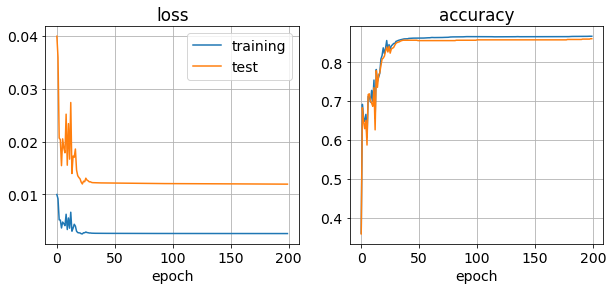

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(1/len(data_train) * np.array(running_loss_train), label="training")
ax[0].plot(1/len(data_test) * np.array(running_loss_test), label="test")
ax[0].set_title("loss")
ax[0].legend()

ax[1].plot(running_accuracy_train, label="training")
ax[1].plot(running_accuracy_test, label="test")
ax[1].set_title("accuracy")

for a in ax:
    a.grid(which="both")
    a.set_xlabel("epoch")

## look at features in network 

In [52]:
ind = 2

print(probs_train[ind, :])
print(f"class: {class_dict[labels_train[ind]]}")

params_train.iloc[ind]

tensor([0., 0., 1.], grad_fn=<SliceBackward>)
class: 30mm


label    2.000000
depth    0.162685
x        0.478193
y        1.200805
z       -0.162685
yaw      2.147772
pitch    0.743857
roll     4.532715
Name: 2, dtype: float64

In [53]:
X_train.shape

torch.Size([4096, 165, 10, 27])

In [54]:
Z0 = []
Z1 = []
Z2 = []
Z3 = []
with torch.no_grad():
    X = X_train[ind:ind+1, :, :, :]
    for Ki, bn in zip(K, batch_norm):
        z0 = functional.conv2d(X, Ki, stride=1, padding=1)
        z1 = bn(z0)
        z2 = functional.relu(z1)
        z3 = functional.max_pool2d(z2, 3, stride=1, padding=1)
        X = z3
        Z0.append(z0)
        Z1.append(z1)
        Z2.append(z2)
        Z3.append(z3)

In [55]:
K[1].shape

torch.Size([11, 33, 3, 3])

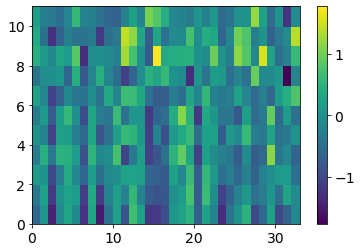

In [56]:
plt.colorbar(plt.pcolormesh(K[1][:, :, 2, 1].data.numpy()))

tensor(-2.7603) tensor(2.7603)


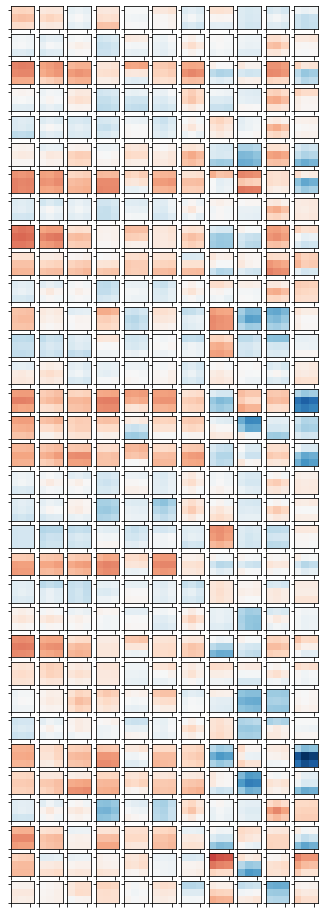

In [57]:
fig, ax = plt.subplots(33, 11, figsize = (11*0.5, 33*0.5))

plotme = K[1].detach()
vmax=np.abs(plotme.flatten()).max()
vmin=-vmax
print(vmin, vmax)

for i in range(33):
    for j in range(11):
        a = ax[i, j]
        a.set_xticklabels('')
        a.set_yticklabels('')
        a.pcolormesh(plotme[j, i, :, :], vmin=vmin, vmax=vmax, cmap="RdBu")
# K[1].shape

In [58]:
Z0[0].shape

torch.Size([1, 33, 10, 27])

In [59]:
W.shape

torch.Size([2970, 3])

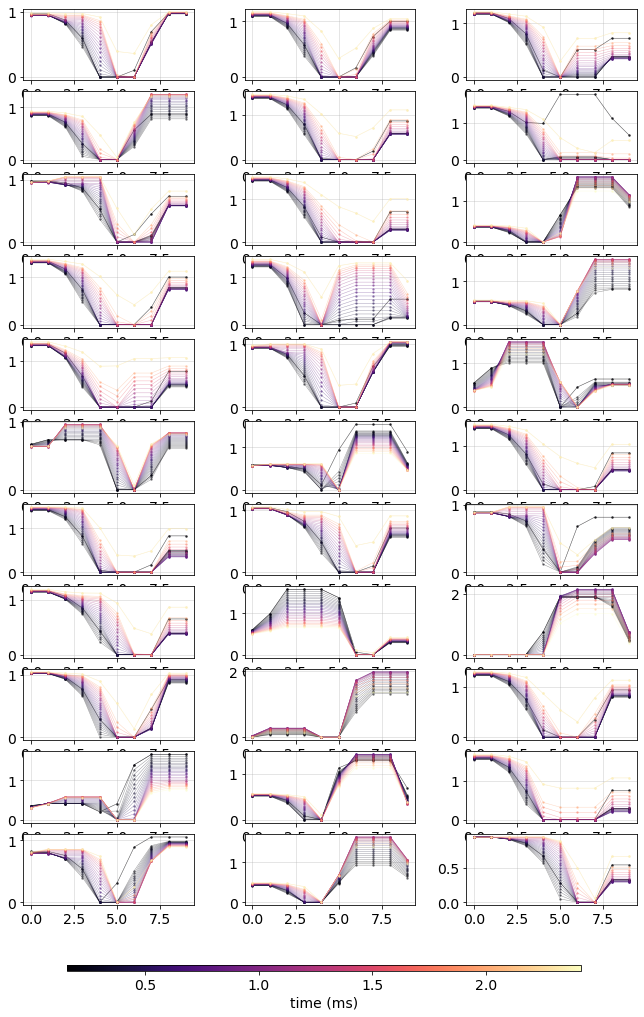

In [60]:
nfeatures = 33
fig, ax = plt.subplots(11, 3, figsize=(11, 1.5*11))
fig.subplots_adjust(wspace=0.3, hspace=0.15)

cm = plt.get_cmap('magma')
c_norm = Normalize(vmin=times.min(), vmax=times.max())
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

plot_me = Z3[0][0, :, :, :]

for i, a in enumerate(ax.flatten()):
    for t in range(len(times)):
        a.plot(
            plot_me[i, :, t], 
            color=scalar_map.to_rgba(times[t]), marker=".", lw=0.5, alpha=0.4, ms=3
        )

        a.grid(which="both", alpha=0.4)
        if rx < nrx-1:
            a.set_xticklabels('')
            
# plt.tight_layout()
cbar_ax = fig.add_axes([0.18, 0.07, 0.65, 0.005])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (ms)')

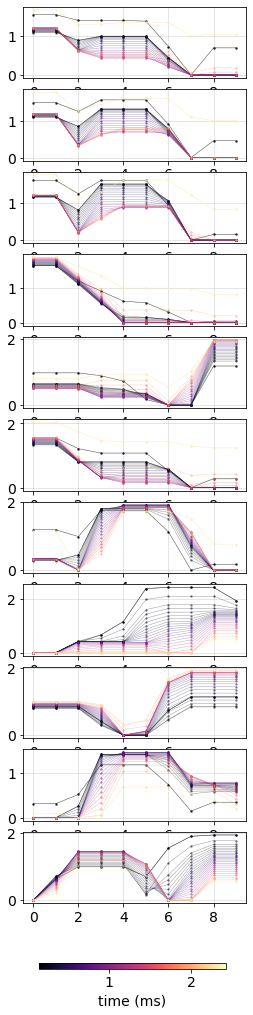

In [61]:
nfeatures = 11
fig, ax = plt.subplots(11, 1, figsize=(4, 1.5*11))
fig.subplots_adjust(wspace=0.3, hspace=0.15)

cm = plt.get_cmap('magma')
c_norm = Normalize(vmin=times.min(), vmax=times.max())
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

plot_me = Z3[1][0, :, :, :]

for i, a in enumerate(ax.flatten()):
    for t in range(len(times)):
        a.plot(
            plot_me[i, :, t], 
            color=scalar_map.to_rgba(times[t]), marker=".", lw=0.5, alpha=0.4, ms=3
        )

        a.grid(which="both", alpha=0.4)
        if rx < nrx-1:
            a.set_xticklabels('')
            
# plt.tight_layout()
cbar_ax = fig.add_axes([0.18, 0.07, 0.65, 0.005])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (ms)')

In [62]:
w_plot = []
with torch.no_grad():
    for i in range(n_class):
        w_plot.append(W[:, i].view(Z3[1].shape).detach())

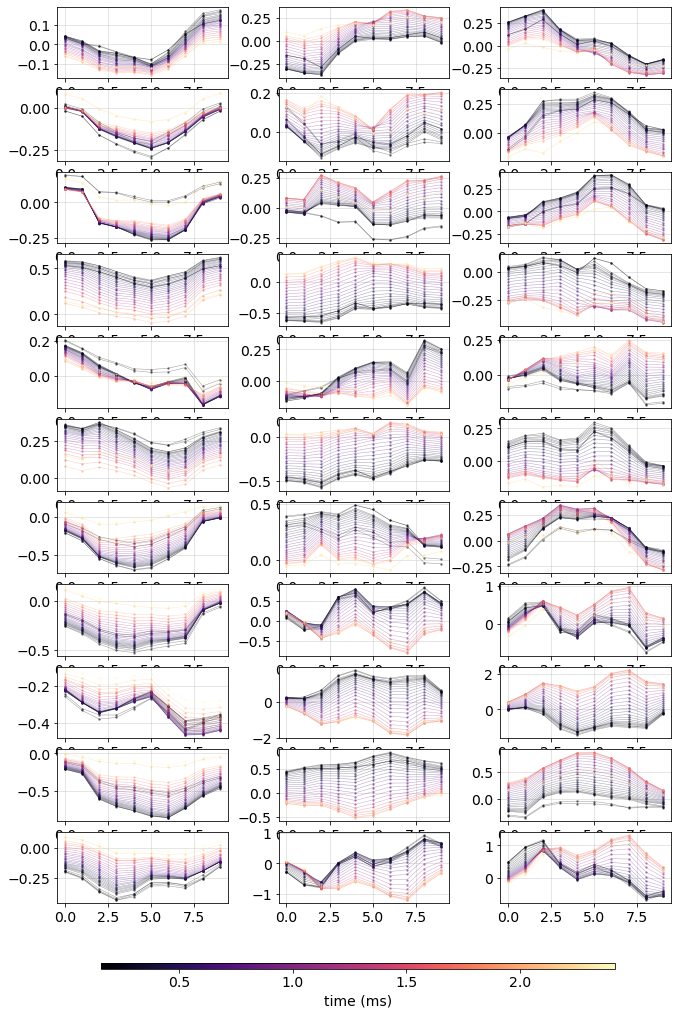

In [63]:
nfeatures = 11
fig, ax = plt.subplots(11, 3, figsize=(11, 1.5*11))
fig.subplots_adjust(wspace=0.3, hspace=0.15)

cm = plt.get_cmap('magma')
c_norm = Normalize(vmin=times.min(), vmax=times.max())
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

for ii, w in enumerate(w_plot):
    for i, a in enumerate(ax[:, ii]):
        for t in range(len(times)):
            a.plot(
                w[0, i, :, t], 
                color=scalar_map.to_rgba(times[t]), marker=".", lw=0.5, alpha=0.4, ms=3
            )

            a.grid(which="both", alpha=0.4)
            if rx < nrx-1:
                a.set_xticklabels('')
            
# plt.tight_layout()
cbar_ax = fig.add_axes([0.18, 0.07, 0.65, 0.005])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (ms)')

# generate a line of data

In [64]:
ymax_profile = 30
nloc_profile = int(ymax_profile/dy)
ncycles_profile = int(nloc_profile/ntx)

y_profile = np.linspace(0, ymax_profile-dy, nloc_profile)
x_profile = np.zeros(nloc_profile)
z_profile = 0.28 * np.ones(nloc_profile)

pitch_profile = np.zeros(nloc_profile)
roll_profile = np.zeros(nloc_profile)
yaw_profile = np.zeros(nloc_profile)  # moving north (sensor in typical orientation)

txnum_profile = np.kron(np.ones(ncycles_profile), np.arange(ntx))

In [65]:
# Convert sensor location coordinates to Rx locations
pos_profile, mnum_profile = sensorCoords2RxCoords(
    sensorinfo=sensorinfo,
    x = x_profile, 
    y = y_profile, 
    z = z_profile, 
    pitch = pitch_profile, 
    roll = roll_profile, 
    yaw = yaw_profile,
    txnum = txnum_profile
)

pitch_profile = np.concatenate([np.tile(x,pos_profile[i].shape[0]) for i,x in enumerate(pitch_profile)])
roll_profile = np.concatenate([np.tile(x,pos_profile[i].shape[0]) for i,x in enumerate(roll_profile)])
yaw_profile = np.concatenate([np.tile(x,pos_profile[i].shape[0]) for i,x in enumerate(yaw_profile)])
pos_profile = np.concatenate(pos_profile,axis=0)

In [66]:
depths_profile = np.r_[0.1, 0.25, 0.5, 0.2, 0.45, 0.7]
params_profile = pd.DataFrame({
    "label": [2, 2, 2, 1, 1, 1],
    "depth": depths_profile,
    "x": np.r_[0, 0, 0, 0, 0, 0],
    "y": np.r_[2, 5, 10, 15, 20, 25],
    "z": -depths_profile,
    "yaw": np.r_[0, np.pi/4, np.pi, 0, np.pi/4, np.pi/2],
    "pitch": np.r_[0, 0, 0, 0, 0, 0],
    "roll": np.r_[0, 0, 0, 0, 0, 0]
})
params_profile

,label,depth,x,y,z,yaw,pitch,roll
0,2,0.10,0,2,-0.10,0.000000,0,0
1,2,0.25,0,5,-0.25,0.785398,0,0
2,2,0.50,0,10,-0.50,3.141593,0,0
3,1,0.20,0,15,-0.20,0.000000,0,0
4,1,0.45,0,20,-0.45,0.785398,0,0
5,1,0.70,0,25,-0.70,1.570796,0,0


In [67]:
# figuring out where all of the vertices are in coordinate system -- gives us location of vertices 
Tx_indices_rot_profile, Rx_indices_rot_profile = preCalcLoopCorners(
    sensorinfo=sensorinfo, mnum=mnum_profile, rlist=pos_profile, pitch=pitch_profile, roll=roll_profile, yaw=yaw_profile
) 

# convienence object for inputs to fwd modelling 
st_profile = FModParam(sensorinfo, pos_profile, mnum_profile, times, Tx_indices_rot_profile, Rx_indices_rot_profile)  



In [68]:
data_profile = run_simulations(params_profile, st=st_profile, mnum=mnum_profile, ncycles=ncycles_profile)

In [69]:
data_profile[0].shape

(165, 150, 27)

In [70]:
X_profile = pos_profile[:, 0].reshape((165, ncycles_profile), order="F")
Y_profile = pos_profile[:, 1].reshape((165, ncycles_profile), order="F")


In [71]:
D_profile = sum(data_profile)
D_profile.shape

(165, 150, 27)

In [72]:
window_width_profile = int(ymax/y_spacing)
w_step_profile = 5
n_windows_profile = (X_profile.shape[1]-window_width_profile)//w_step_profile
print(n_windows_profile)

28


In [73]:
n = D_profile.shape
net_data_profile = np.zeros((n_windows_profile, n[0], window_width_profile, n[2]))
net_y_profile = np.zeros((n_windows_profile, n[0], window_width_profile))
net_x_profile = np.zeros((n_windows_profile, n[0], window_width_profile))

for i in range(n_windows_profile):
    inds = slice(i*w_step_profile,i*w_step_profile+window_width_profile)
    net_x_profile[i, :, :] = X_profile[:, inds]
    net_y_profile[i, :, :] = Y_profile[:, inds]
    net_data_profile[i, :, :, :] = D_profile[:, inds, :]

In [74]:
if use_scaled is True:
    net_data_profile_torch = torch.from_numpy(np.float32(net_data_profile*time_scaling))
else:
    net_data_profile_torch = torch.from_numpy(np.float32(net_data_profile))

In [75]:
with torch.no_grad():
    out_field = net(net_data_profile_torch, K, batch_norm)
    n = W.shape
    S = torch.matmul(out_field.view(-1, n[0]), W)
    probs_profile = functional.softmax(S, dim=1)

In [76]:
_, labels_profile = torch.max(probs_profile, dim=1)

In [77]:
D_profile[mnum, :, :].shape

(1650, 150, 27)

In [78]:
from matplotlib.lines import Line2D

(-2, 8)

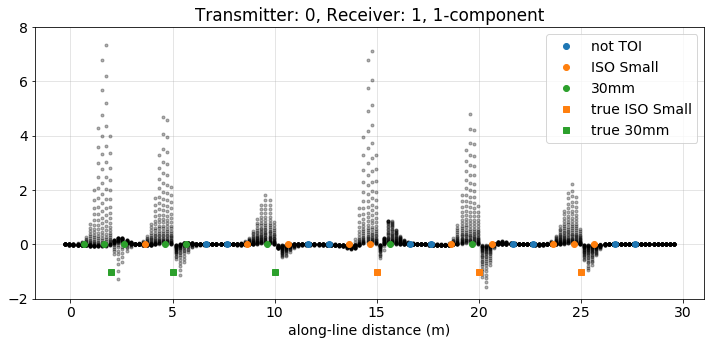

In [79]:
mnum_plot = 12
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

ordnance_labels = [
    Line2D(
        [0], [0], marker='o', color="w", 
        markerfacecolor=f'C{int(key)}', markeredgecolor=f'C{int(key)}', 
        label=value
    ) for key, value in class_dict.items()
]

ordnance_labels = ordnance_labels + [
    Line2D(
        [0], [0], marker='s', color="w", 
        markerfacecolor=f'C{int(key)}', markeredgecolor=f'C{int(key)}', 
        label=f"true {class_dict[key]}"
    ) for key in [1, 2]
]

ax.plot(Y_profile[mnum_plot, :], D_profile[mnum_plot, :, :], '.', color="k", alpha=0.3)
ax.grid("both", alpha=0.4)

for i in range(net_data_profile.shape[0]):
    y_plot = np.mean(net_y_profile[i, mnum_plot, :])
    ax.plot(y_plot, 0, f'C{labels_profile[i]}o')

txnumplot = sensor_table[mnum_plot, 0]
rxnumplot = sensor_table[mnum_plot, 3]
rxcompplot = sensor_table[mnum_plot, 2]
ax.set_title(f"Transmitter: {txnumplot}, Receiver: {rxnumplot}, {rxcompplot}-component")
ax.set_xlabel("along-line distance (m)")

for i in range(len(depths_profile)):
    label = params_profile["label"][i]
    ax.plot(params_profile["y"][i], -1, f"sC{label}")

ax.legend(handles=ordnance_labels)

# ax.set_xlim([-10, 0])
ax.set_ylim([-2, 8])


In [80]:
probs_profile

tensor([[0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 1.0000e+00, 1.2050e-10],
        [0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 1.1837e-31, 1.0000e+00],
        [1.0000e+00, 1.5949e-14, 5.8458e-20],
        [1.0000e+00, 1.2469e-16, 5.5573e-21],
        [7.8568e-39, 1.0000e+00, 1.1910e-28],
        [0.0000e+00, 1.3990e-23, 1.0000e+00],
        [1.5780e-41, 9.8949e-01, 1.0510e-02],
        [1.0000e+00, 1.7496e-15, 1.0024e-20],
        [1.0000e+00, 1.9268e-13, 2.9272e-19],
        [0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 9.9983e-01, 1.6639e-04],
        [0.0000e+00, 0.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.5500e-10, 2.4176e-17],
        [1.0000e+00, 3.1609e-15, 1.3014e-19],
        [0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 3.6406e-10, 1.0000e+00],
        [0.0000e+00, 1.0000e+00, 1.4251e-10],
        [1.0000e+00, 1.8786e-13, 8

# load up a line from the test site

In [81]:
data_directory = "../UXO_protected/data-blacktusk"
groundtruth = pd.read_excel(os.path.sep.join([data_directory, "groundtruth_Testplot5F.xlsx"]), nrows=93)

In [82]:
groundtruth = pd.read_excel(os.path.sep.join([data_directory, "groundtruth_Testplot5F.xlsx"]), nrows=93)

In [83]:
# H5 functions
def proc_attr(inp):
    """HDF5 - Process attributes for the input group and return them in a dictionary."""
    dic = {}
    for att in inp.attrs.keys():
        if inp.attrs[att].dtype.char == 'S':
            dic[att] = [x.strip() for x in inp.attrs[att].tostring().decode('ascii').split(',')]
        else:
            dic[att] = inp.attrs[att][0] if isinstance(inp.attrs[att],np.ndarray) and inp.attrs[att].size==1 else inp.attrs[att]
    return dic
    pass

def proc_group(inp):
    """HDF5 - A recursive function for reading datasets and attributes into a dictionary."""
    dic = {}
    dic.update(proc_attr(inp))
    for key in inp.keys():
        if isinstance(inp[key], h5py.Group):
            dic.update({key:proc_group(inp[key])})
        else:
            dic[key] = inp[key][()]
        pass
    return dic

In [84]:
dfile = os.path.join(data_directory, 'Testplot5F.h5')
f = h5py.File(dfile, 'r')
dic = proc_group(f)
f.close()

In [85]:
# Generate the sensorinfo structure
sensor_name = dic['SensorName'][0]
sensor_config = dic['SensorConfig'][0]
afile = os.path.join(code_dir,'config','sensor_definitions','{}___{}.yaml'.format(sensor_name,sensor_config))
sensorinfo = SensorInfo.fromYAML(afile)[0]

print(sensor_name)

UltraTEMArrayNA


In [86]:
xyz_dict = dic["XYZ"]
ch = xyz_dict['Info']['ChannelNames']
datai = xyz_dict['Info']['Data']['ChannelIndex'].flatten().astype(int)-1 # These are indices to the decay data
yawi = int(xyz_dict['Info']['Yaw']['ChannelIndex'])-1 # index to the yaw channel
mni = int(xyz_dict["Info"]["MeasNum"]["ChannelIndex"])-1
easting = int(xyz_dict["Info"]["Easting"]["ChannelIndex"])-1
northing = int(xyz_dict["Info"]["Northing"]["ChannelIndex"])-1
linesi = int(xyz_dict["Info"]["Line"]["ChannelIndex"])-1
rx_num = int(xyz_dict["Info"]["RxNum"]["ChannelIndex"])-1
tx_num = int(xyz_dict["Info"]["TxNum"]["ChannelIndex"])-1
rx_comp = int(xyz_dict["Info"]["RxCNum"]["ChannelIndex"])-1
rx_num = int(xyz_dict["Info"]["RxNum"]["ChannelIndex"]) - 1

times = np.array(dic['SensorTimes'].flatten())
print(times.min(), times.max(), len(times))

0.154 2.42 27


In [87]:
xyz_data = xyz_dict["Data"]
mn = xyz_data[mni, :].astype(int) - 1

In [88]:
line_id = 1013 #, 1013]
line_inds = xyz_data[linesi, :] == line_id
print(sum(line_inds))

66825


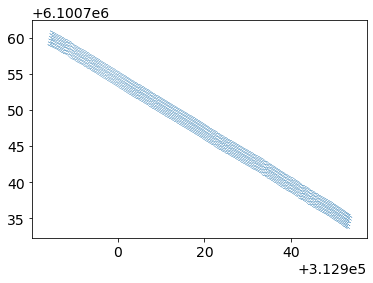

In [89]:
fig, ax = plt.subplots(1, 1)
ax.plot(xyz_data[easting, line_inds], xyz_data[northing, line_inds], '.', alpha=0.1, ms=0.2)

In [90]:
from scipy import stats

In [91]:
# local coordinates for the data set 
x0, y0 = np.mean(xyz_data[easting, :]), np.mean(xyz_data[northing, :])
local_easting = xyz_data[easting, :] - x0
local_northing = xyz_data[northing, :] - y0

slope, intercept, _, _, _ = stats.linregress(local_easting, local_northing)
print(slope, intercept)

-0.3486944749895923 6.346738382583072e-10


In [92]:
theta = np.arctan(slope)+np.pi/2
local_x = np.cos(theta) * local_easting + np.sin(theta) * local_northing
local_y = -np.sin(theta) * local_easting + np.cos(theta) * local_northing


local_ground_truth_easting = np.array(groundtruth["Easting"] - x0)
local_ground_truth_northing = np.array(groundtruth["Northing"] - y0)
local_ground_truth_x = np.cos(theta) * local_ground_truth_easting + np.sin(theta) * local_ground_truth_northing
local_ground_truth_y = -np.sin(theta) * local_ground_truth_easting + np.cos(theta) * local_ground_truth_northing


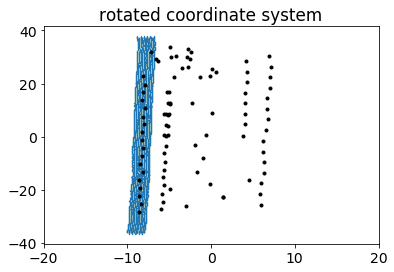

In [93]:
line_x = local_x[line_inds]
line_y = local_y[line_inds]

mn_line = mn[line_inds]
fig, ax = plt.subplots(1, 1)
ax.plot(line_x, line_y, '.', ms=0.1)
ax.set_xlim(np.r_[-20, 20])
ax.set_title("rotated coordinate system")

ax.plot(local_ground_truth_x, local_ground_truth_y, 'k.', label="ordnance")

In [94]:
ord_inds_covered = (
    (local_ground_truth_x >= line_x.min()) & (local_ground_truth_x <= line_x.max()) &
    (local_ground_truth_y >= line_y.min()) & (local_ground_truth_y <= line_y.max())
)

Text(0, 0.5, 'y (m)')

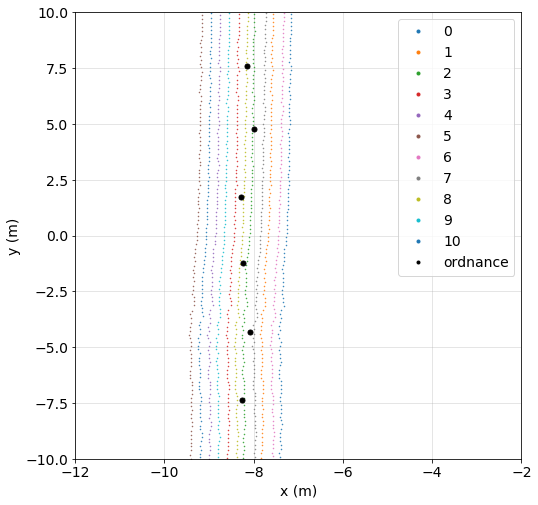

In [95]:
mn_line = mn[line_inds]
fig, ax = plt.subplots(1, 1, figsize=(8, 14))

for plot_mn in range(11):

    plot_inds = (mn_line==plot_mn)
    ax.plot(line_x[plot_inds], line_y[plot_inds], '.', ms=1, label=plot_mn)

ax.plot(
    local_ground_truth_x[ord_inds_covered], local_ground_truth_y[ord_inds_covered], 'k.', label="ordnance", ms=10
)
lgnd = ax.legend()
[h._legmarker.set_markersize(6) for h in lgnd.legendHandles]

ax.set_xlim([-12, -2])
ax.set_ylim([-10, 10])
ax.grid("both", alpha = 0.4)
ax.set_aspect(0.5)
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")

In [96]:
# target data shape 165 X nlocs X nTimes 
# grab by measurement number 
# then re-stack

x_locs = []
y_locs = []
data_list = []
line_data = xyz_data[datai, :][:, line_inds]

for mnind in range(mn.max() + 1):
    mninds = mn_line == mnind
    x_locs.append(line_x[mninds])
    y_locs.append(line_y[mninds])
    data_list.append(line_data[:, mninds].T)

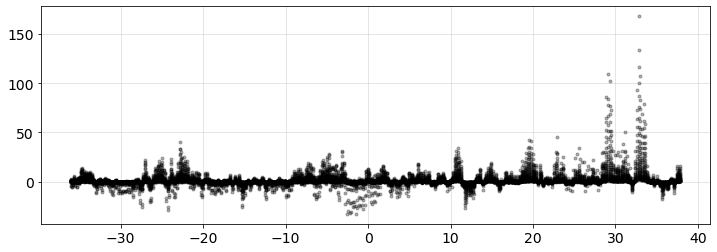

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(y_locs[0], data_list[0], '.', color="k", alpha=0.3)
ax.grid("both", alpha=0.4)

In [98]:
X_locs = np.vstack(x_locs)
Y_locs = np.vstack(y_locs)
S_data = np.stack(data_list, axis=0)
print(S_data.shape)

(165, 405, 27)


In [99]:
window_width = int(ymax/y_spacing)
w_step = 5
n_windows = (X_locs.shape[1]-window_width)//w_step + 1
print(n_windows)

80


In [100]:
n = S_data.shape
net_data = np.zeros((n_windows, n[0], window_width, n[2]))
net_y = np.zeros((n_windows, n[0], window_width))
net_x = np.zeros((n_windows, n[0], window_width))

for i in range(n_windows):
    inds = slice(i*w_step,i*w_step+window_width)
    net_x[i, :, :] = X_locs[:, inds]
    net_y[i, :, :] = Y_locs[:, inds]
    net_data[i, :, :, :] = S_data[:, inds, :]

In [101]:
net_data_torch = torch.from_numpy(np.float32(net_data))

In [102]:
with torch.no_grad():
    out_field = net(net_data_torch, K, batch_norm)
    n = W.shape
    S = torch.matmul(out_field.view(-1, n[0]), W)
    probs_field = functional.softmax(S, dim=1)

In [103]:
probs_field

tensor([[1.1456e-31, 1.0000e+00, 2.8496e-19],
        [0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 1.9981e-34],
        [0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00],
        [1.2892e-32, 1.0000e+00, 7.3405e-27],
        [3.1756e-24, 1.0000e+00, 0.0000e+00],
        [1.1455e-37, 1.0000e+00, 1.8665e-42],
        [0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 9.9995e-01, 4.6299e-05],
        [0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1

In [104]:
_, labels_field = torch.max(probs_field, axis=1)

In [105]:
from matplotlib.lines import Line2D

(-50, 50)

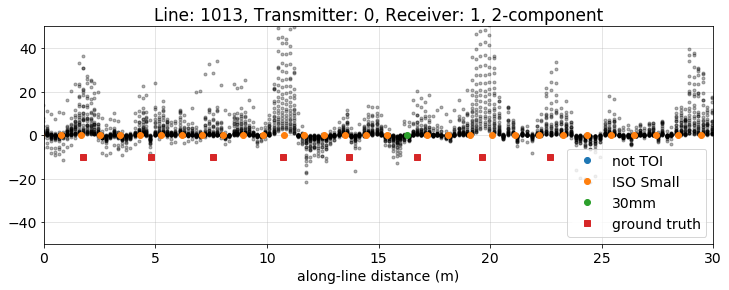

In [106]:
mnum_plot = 1
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

ordnance_labels = [
    Line2D(
        [0], [0], marker='o', color="w", 
        markerfacecolor=f'C{int(key)}', markeredgecolor=f'C{int(key)}', 
        label=value
    ) for key, value in class_dict.items()
]

ordnance_labels.append(
    Line2D(
        [0], [0], marker='s', color="w", 
        markerfacecolor=f'C3', markeredgecolor=f'C3', 
        label="ground truth"
    )
)

ax.plot(y_locs[mnum_plot], data_list[mnum_plot], '.', color="k", alpha=0.3)
ax.grid("both", alpha=0.4)

for i in range(net_data.shape[0]):
    y_plot = np.mean(net_y[i, mnum_plot, :])
    ax.plot(y_plot, 0, f'C{labels_field[i]}o')

txnumplot = sensor_table[mnum_plot, 0]
rxnumplot = sensor_table[mnum_plot, 3]
rxcompplot = sensor_table[mnum_plot, 2]
ax.set_title(f"Line: {line_id}, Transmitter: {txnumplot}, Receiver: {rxnumplot}, {rxcompplot}-component")
ax.set_xlabel("along-line distance (m)")
ax.plot(local_ground_truth_y[ord_inds_covered], -10*np.ones(ord_inds_covered.sum()), "sC3")

ax.legend(handles=ordnance_labels)

ax.set_xlim([0, 30])
ax.set_ylim([-50, 50])


In [107]:
groundtruth["ItemBuried"][ord_inds_covered]

9     Small ISO
10    Small ISO
11    Small ISO
12    Small ISO
13    Small ISO
14    Small ISO
15    Small ISO
16    Small ISO
17    Small ISO
18    Small ISO
19    Small ISO
20    Small ISO
21    Small ISO
22    Small ISO
23    Small ISO
24    Small ISO
25    Small ISO
26    Small ISO
84    Small ISO
Name: ItemBuried, dtype: object

In [108]:
groundtruth["Comment"][ord_inds_covered]

9     10_SmlISO_0.2_Ha
10    11_SmlISO_0.2_Hx
11     12_SmlISO_0.2_V
12    13_SmlISO_0.3_Ha
13    14_SmlISO_0.3_Hx
14     15_SmlISO_0.3_V
15    16_SmlISO_0.4_Ha
16    17_SmlISO_0.4_Hx
17     18_SmlISO_0.4_V
18    19_SmlISO_0.5_Ha
19    20_SmlISO_0.5_Hx
20     21_SmlISO_0.5_V
21    22_SmlISO_0.6_Ha
22    23_SmlISO_0.6_Hx
23     24_SmlISO_0.6_V
24    25_SmlISO_0.7_Ha
25    26_SmlISO_0.7_Hx
26     27_SmlISO_0.7_V
84          Saturated 
Name: Comment, dtype: object